# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Project Defnetion
### Project Overview
This project analyzes customer purchasing behavior in response to different promotional offers issued by Starbucks. The primary objective is to identify which types of offers (Buy-One-Get-One [BOGO], discount, informational) are most effective for various customer segments. By leveraging simulated data that captures customer demographics, transaction histories, and interactions with promotional offers, we aim to develop insights that can optimize Starbucks' marketing strategies to enhance customer engagement and boost revenue.


### Import useful Libraries

In [275]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

## Section : Data Understanding
#### Gether data

In [89]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [90]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


10 events in total.

In [91]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


17k is the total number of users.

In [92]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### Assess Data

In [93]:
profile.isna().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [94]:
(~profile['gender'].isna() & profile['income'].isna()).sum()

0

From this we can tell that there is 12.8% of the users have NAN gender and NAN income at the same time. Which we might consider dropping them.

In [95]:
profile.duplicated().sum()

0

In [96]:
ids_na = profile[profile['gender'].isna()]['id']

<Axes: title={'center': 'Age Distribution'}>

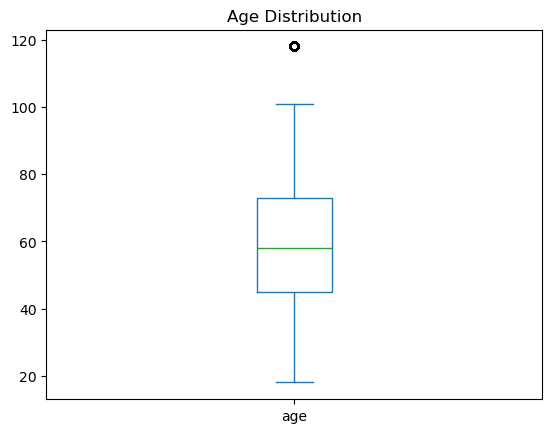

In [97]:
profile['age'].plot(kind='box', title = 'Age Distribution')

From the figure above, we might find outliers at age 118.

In [98]:
profile['age'].quantile(0.75)

73.0

<Axes: title={'center': 'Income Distribution'}>

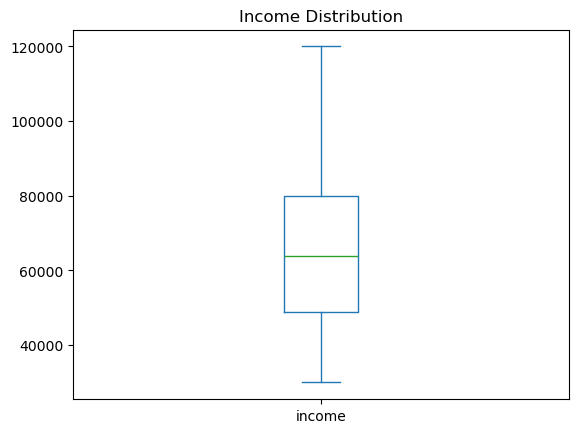

In [99]:
profile['income'].plot(kind = 'box', title = 'Income Distribution')

<Axes: title={'center': 'Genders'}, ylabel='count'>

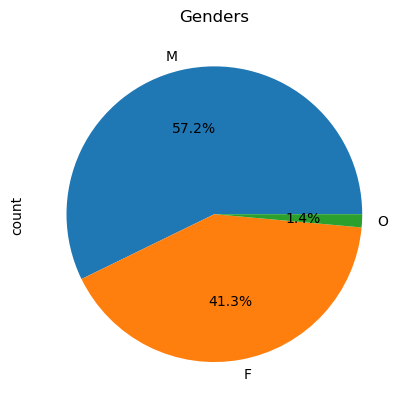

In [100]:
profile['gender'].dropna().value_counts().plot(kind= 'pie',autopct = '%1.1f%%', title = 'Genders')

In [101]:
# Checking Null values
transcript.isna().mean()

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

In [102]:
transcript[transcript['event']=='offer received']['value'].head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [103]:
# Checking the unique events
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

<Axes: title={'center': 'Events'}, ylabel='count'>

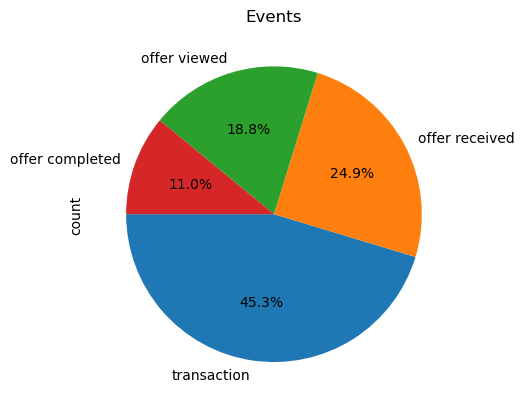

In [104]:
transcript['event'].value_counts().plot(kind='pie',autopct='%1.1f%%',startangle=180, title = 'Events')

Almost **25%** of the events belongs to `offer received`, while the offers being viewed  `offer viewed` make up about **75%** of the total offers.

The good thing is that almost **45%** of the offers are being completed `offer completed`.

In [105]:
transcript[transcript['event'] == 'transaction']['person'].value_counts().sort_values(ascending = False).head(10)

person
79d9d4f86aca4bed9290350fb43817c2    36
8dbfa485249f409aa223a2130f40634a    36
94de646f7b6041228ca7dec82adb97d2    35
b1f4ece7d49342628a9ed77aee2cde58    32
5e60c6aa3b834e44b822ea43a3efea26    32
a42ed50acc4d4b25bca647c9e0b916ad    31
d0a80415b84c4df4908b8403b19765e3    30
ab25fd6fbd5040f880751921e4029757    30
40ce078d5b2a43d19138a788754520be    30
4142f5e23db741b1af4be0287dc91c1c    30
Name: count, dtype: int64

The highest number of transactions made by one person is **36**.

In [106]:
profile[profile['id'].isin(transcript[transcript['event'] == 'transaction']['person'].value_counts().sort_values(ascending = False).index[0:10])]

,gender,age,id,became_member_on,income
1485,M,37,b1f4ece7d49342628a9ed77aee2cde58,20180105,64000.0
3108,M,27,94de646f7b6041228ca7dec82adb97d2,20140126,33000.0
3953,F,62,a42ed50acc4d4b25bca647c9e0b916ad,20161017,33000.0
5978,M,53,d0a80415b84c4df4908b8403b19765e3,20160218,37000.0
6363,M,63,8dbfa485249f409aa223a2130f40634a,20151118,48000.0
6472,M,35,ab25fd6fbd5040f880751921e4029757,20150901,49000.0
6663,M,59,5e60c6aa3b834e44b822ea43a3efea26,20141120,55000.0
7672,M,61,40ce078d5b2a43d19138a788754520be,20160502,31000.0
10250,M,76,79d9d4f86aca4bed9290350fb43817c2,20150423,34000.0
11591,M,47,4142f5e23db741b1af4be0287dc91c1c,20171225,36000.0


The top 10 numbers of transactions, 9 of them were made by male users while 1 transaction only was made by a female one.

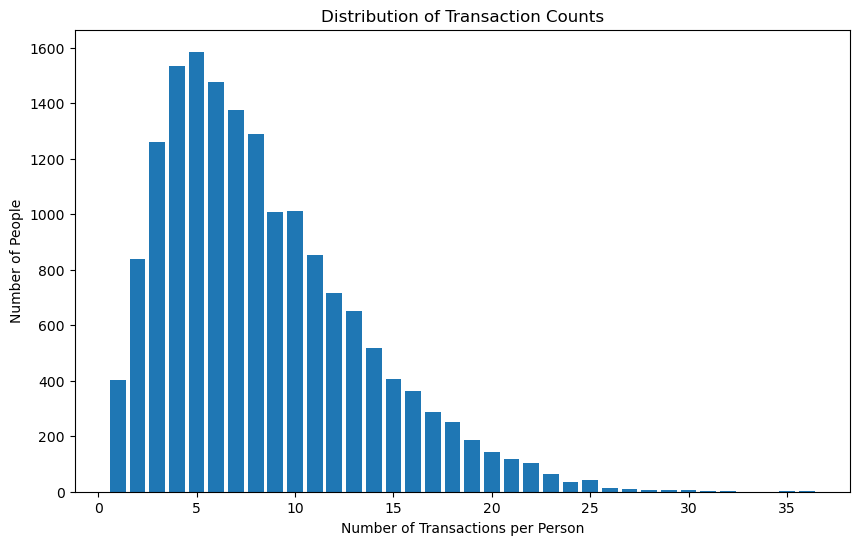

In [107]:
# Plotting the value_counts
value_counts = transcript[transcript['event'] == 'transaction']['person'].value_counts().sort_values(ascending=False).value_counts()
plt.figure(figsize=(10, 6))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Number of Transactions per Person')
plt.ylabel('Number of People')
plt.title('Distribution of Transaction Counts')
plt.show()

In [108]:
value_counts.loc[range(1,4)].sum()/value_counts.sum()

0.15086258897333815

In [109]:
value_counts.loc[range(4,11)].sum()/value_counts.sum()

0.5600193026903124

In [110]:
# The +3 in the next line because there is no user with 33 or 34 transactions 
# However, there is 1 person with 35 and 2 with 36 transactions.
# So 3 added.
(value_counts.loc[range(11,33)].sum()+3)/value_counts.sum()

0.2891181083363494

Most Common Transaction Counts:

The highest frequency is for 5 transactions, suggesting that many users tend to perform around 5 transactions.
Similarly, the frequencies for 4, 6, and 7 transactions are also quite high.

User Engagement Segmentation:

Using this data to segment users based on their activity levels.

    For instance:
    Users making 1–3 transactions could be considered low-engagement users. 15%
    Users making 4–10 transactions could be medium-engagement. 56%
    Users making more than 10 transactions could be high-engagement users. 29%

More than half of users will belong to the medium-engagement segment.

In [111]:
# Let's find how many transactions that people with NAN values have done so far.
transcript[transcript['person'].isin(ids_na)]['event'].value_counts()

event
transaction        14996
offer received      9776
offer viewed        7865
offer completed     1135
Name: count, dtype: int64

<Axes: title={'center': 'Events portions but for people to be dropped'}, ylabel='count'>

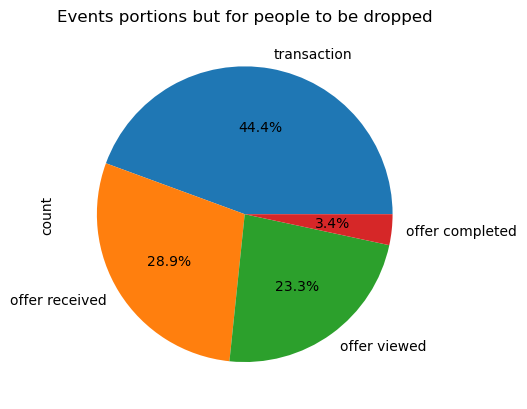

In [112]:
transcript[transcript['person'].isin(ids_na)]['event'].value_counts().plot(kind='pie',
                                                                           autopct = '%1.1f%%',
                                                                           title = 'Events portions but for people to be dropped')

In [113]:
# Let's find the portion of events that people with NAN values have done so far.
transcript[transcript['person'].isin(ids_na)]['event'].value_counts().sum()/transcript.shape[0]

0.11017374907840566

These people have completed less than **9%** of the received offers.

**11%** of the total events is not a small portions to ignor; however, as we are focusing on the offers only, we might consider dropping these people.

## Section : Data Preparation

#### Data Cleaning


As noticed, we don't have these 118 years old people alive in the real world. which should be dropped.

Also, users with unknown income and gender, since we cannot make useful insights from `age`, `id`, and `become_member_on` columns only.

In [114]:
# First drop na
profile_clean = profile.copy() # intial copy
profile_clean.dropna(axis = 0, inplace = True)

#Drop these people events
transcript_clean = transcript.copy()# intial copy
transcript_clean = transcript_clean[~transcript_clean['person'].isin(ids_na)]


After dropping the NANs, let's drop the outliers as discussed before.

In [115]:
Q3 = profile_clean['age'].quantile(0.75)
Q1 = profile_clean['age'].quantile(0.25)
IQR = Q3 - Q1
highest_threshold = 1.5* IQR + Q3
highest_threshold

102.0

In [116]:
profile_clean = profile_clean[profile_clean['age'] < highest_threshold]
print(profile_clean.shape)
profile_clean.head()

(14825, 5)


,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


Seems like nothing happened here (*No dropped rows*), but at least now we are sure that there is no fake values so far.

In [117]:
print(transcript_clean.shape)
transcript_clean.head()

(272762, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


#### Data Preprocessing and Visualization

In [118]:
# Let's do some preprocessing on value column
# Assuming 'transcript_clean' is your original dataframe
# Normalize the 'value' column and rename columns for consistency
norma = pd.json_normalize(transcript_clean['value']).rename(columns={'offer id': 'offer_id_1', 'offer_id': 'offer_id_2'})

# Reset indices before concatenation to avoid misalignment
transcript_clean.reset_index(drop=True, inplace=True)
norma.reset_index(drop=True, inplace=True)

# Concatenate the original dataframe without the 'value' column with the normalized dataframe
both = pd.concat([transcript_clean.drop('value', axis=1), norma], axis=1)

# Create a single 'offer_id' column, using values from 'offer_id_1' and 'offer_id_2'
both['offer_id'] = both['offer_id_1'].combine_first(both['offer_id_2'])

# Drop the redundant columns
transcript_clean = both.drop(columns=['offer_id_1', 'offer_id_2'])
transcript_clean = transcript_clean.fillna(0)
print(transcript_clean.shape)
transcript_clean.head()

(272762, 6)


,person,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,0,0.0,0.0,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,0.0,0.0,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [119]:
transcript_clean[transcript_clean['event'] == 'offer completed'].value_counts('offer_id')

offer_id
fafdcd668e3743c1bb461111dcafc2a4    5003
2298d6c36e964ae4a3e7e9706d1fb8c2    4886
9b98b8c7a33c4b65b9aebfe6a799e6d9    4188
f19421c1d4aa40978ebb69ca19b0e20d    4103
2906b810c7d4411798c6938adc9daaa5    3911
ae264e3637204a6fb9bb56bc8210ddfd    3657
0b1e1539f2cc45b7b9fa7c272da2e1d7    3386
4d5c57ea9a6940dd891ad53e9dbe8da0    3310
Name: count, dtype: int64

By counting the completed events and merging them with the event table, we can gain clearer insights.

However, you'll notice that there are only 8 offers instead of 10. Therefore, let's include the informational offer completed during the offer period as a completed offer.

In [121]:
# Assume portfolio_clean and transcript_clean DataFrames are already defined

# Get the list of informational offers with their duration
informational_offers = portfolio[portfolio['offer_type'] == 'informational'][['id', 'duration']]

# Sort transcript_clean by user and time to maintain a chronological order
# Create a copy to avoid modifying the original DataFrame directly
transcript_updated = transcript_clean.sort_values(by=['person', 'time']).reset_index(drop=True).copy()

# Iterate over users
for user_id in transcript_clean['person'].unique():
    # Get all events related to the user
    user_events = transcript_clean[transcript_clean['person'] == user_id]
    
    # Iterate over each informational offer
    for _, row in informational_offers.iterrows():
        offer_id = row['id']
        offer_duration = row['duration'] * 24 

        # Find the "offer received" event for the current offer
        received_events = user_events[(user_events['offer_id'] == offer_id) & (user_events['event'] == 'offer received')]
        
        if not received_events.empty:
            # Get the time of the last "offer received" event
            received_time = received_events['time'].values[-1]
            offer_expiry_time = received_time + offer_duration

            # Check if there was a "viewed" event within the offer duration
            viewed_events = user_events[(user_events['offer_id'] == offer_id) & 
                                        (user_events['event'] == 'offer viewed') & 
                                        (user_events['time'] <= offer_expiry_time)]
            
            if not viewed_events.empty:
                # Get the time of the last viewing event
                viewed_time = viewed_events['time'].values[-1]

                # Check for a subsequent transaction within the offer duration
                transaction_events = user_events[(user_events['event'] == 'transaction') & 
                                                 (user_events['time'] > viewed_time) & 
                                                 (user_events['time'] <= offer_expiry_time)]
                
                if not transaction_events.empty:
                    # Get the time of the transaction
                    transaction_time = transaction_events['time'].values[0]

                    # Create a new row representing "offer completed"
                    new_row = {
                        'person': user_id,
                        'event': 'offer completed',
                        'time': transaction_time + 1,  # Adding a small time increment to insert after transaction
                        'offer_id': offer_id,
                    }

                    # Append the new row to the updated DataFrame
                    transcript_updated = pd.concat([transcript_updated, pd.DataFrame([new_row])], ignore_index=True)

# Sort the updated DataFrame to maintain chronological order
transcript_updated = transcript_updated.sort_values(by=['time','person']).reset_index(drop=True)

transcript_clean = transcript_updated

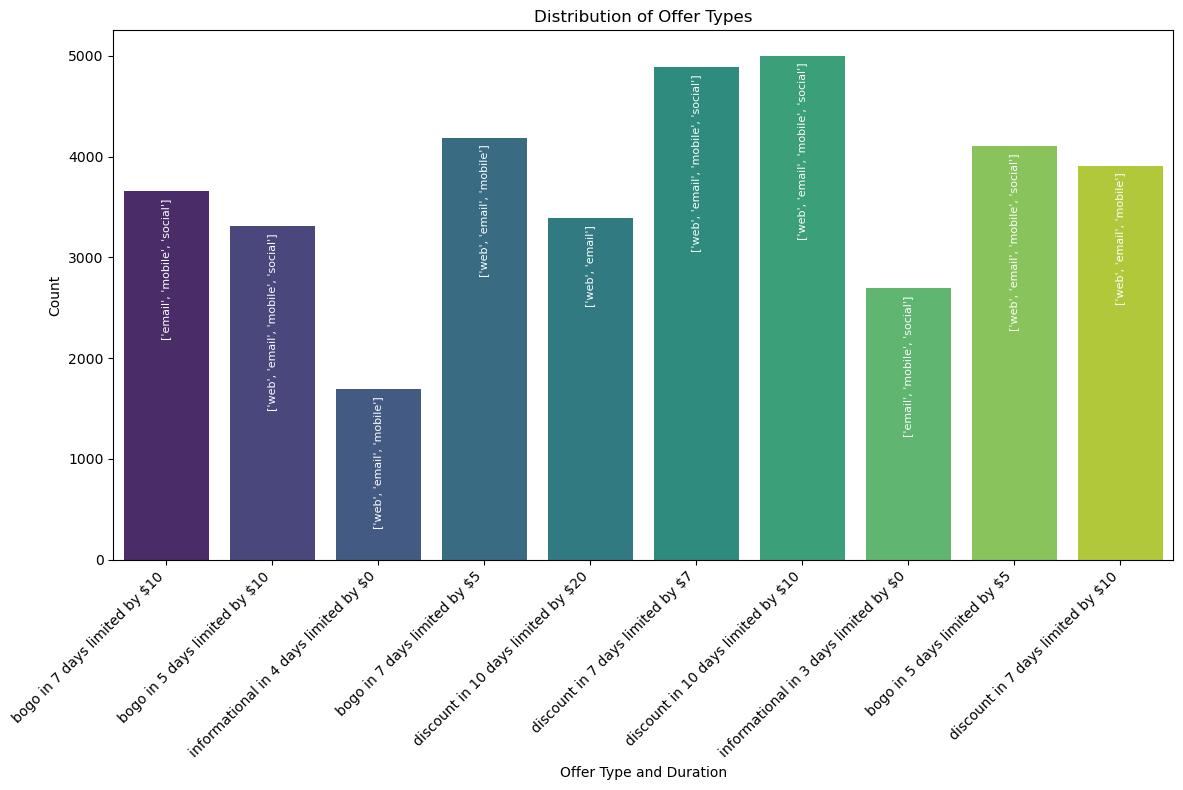

In [145]:
count_merged_df = portfolio.merge(transcript_clean[transcript_clean['event'] == 'offer completed'].value_counts('offer_id'), left_on= 'id', right_on= 'offer_id')
# Step 1: Create x-axis labels by combining 'offer_type', 'duration', and 'difficulty'
count_merged_df['x_axis'] = count_merged_df['offer_type'] + ' in ' + count_merged_df['duration'].astype(str) + ' days limited by $' + count_merged_df['difficulty'].astype(str)

# Filter the DataFrame to only include rows with a non-zero count
filtered_df = count_merged_df[count_merged_df['count'] != 0]

# Step 2: Plotting
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='x_axis', y='count', data=filtered_df, palette='viridis', hue = count_merged_df['x_axis'], legend = False)

# Step 3: Adding channel information to each bar
i= 0
for _, row in filtered_df.iterrows():
    bar_plot.text(i, row['count'], 
                  f"{row['channels']}  ", 
                  color='white', 
                  ha='center', 
                  va= 'top',
                  rotation=90,
                  fontsize = 8)
    i = i+1

plt.title('Distribution of Offer Types')
plt.xlabel('Offer Type and Duration')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to make room for the labels
plt.show()

We can tell that the highest completed offer is `discount` with duration and difficulty = **10** through web, email, mobile, and social.

The following is converting the channels list to be in one hot encoding to help modeling.

In [176]:
transcript_clean.head()

,person,event,time,amount,reward,offer_id
0,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,0.0,0.0,3f207df678b143eea3cee63160fa8bed
1,0020c2b971eb4e9188eac86d93036a77,offer received,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4
2,003d66b6608740288d6cc97a6903f4f0,offer received,0,0.0,0.0,5a8bc65990b245e5a138643cd4eb9837
3,00426fe3ffde4c6b9cb9ad6d077a13ea,offer received,0,0.0,0.0,5a8bc65990b245e5a138643cd4eb9837
4,005500a7188546ff8a767329a2f7c76a,offer received,0,0.0,0.0,ae264e3637204a6fb9bb56bc8210ddfd


In [123]:
# Assuming 'merged_df' is your dataframe after merging counts with events
# Expand the 'channels' column into multiple columns with binary values

# Step 1: Convert the 'channels' column to a DataFrame with one-hot encoding
channels_df = count_merged_df['channels'].apply(lambda x: pd.Series({ch: 1 for ch in x})).fillna(0).astype(int)

# Step 2: Rename the columns for clarity
channels_df.columns = [f'channel_{col}' for col in channels_df.columns]

# Step 3: Concatenate the expanded 'channels' with the original dataframe
merged_df_expanded = pd.concat([count_merged_df.drop(columns=['channels', 'count','x_axis']), channels_df], axis=1)
merged_df_expanded

,reward,difficulty,duration,offer_type,id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [125]:
portfolio_clean = merged_df_expanded

Next is comparing between the events before and after dropping the misleading values.

Text(0.5, 1.0, 'Original Transcript Events')

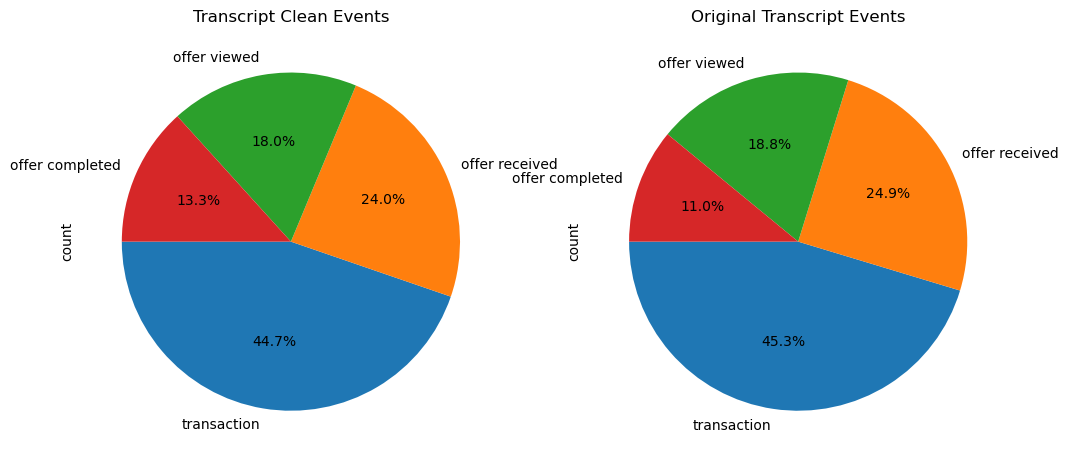

In [126]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

transcript_clean['event'].value_counts().plot(kind='pie',autopct='%1.1f%%',startangle=180, ax = axes[0])
axes[0].set_title('Transcript Clean Events')  # Title for the first pie chart
transcript['event'].value_counts().plot(kind='pie',autopct='%1.1f%%',startangle=180, ax = axes[1])
axes[1].set_title('Original Transcript Events')  # Title for the second pie chart

As noticed, the portion of offers completed has increased after cleaning some wrong entered data.

Next, adding more columns in the `profile_clean` dataframe to help understand how many offers each user has completed, viewed, or just received.

In [127]:
# Step 1: Filter the transcript for relevant events and count each event by person
event_counts = (
    transcript_clean[transcript_clean['event'].isin(['offer received', 'offer viewed', 'offer completed', 'transaction'])]
    .groupby(['person', 'event'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 2: Rename columns for clarity
event_counts.columns = ['person', 'offer_completed', 'offer_received', 'offer_viewed', 'transactions']

# Step 3: Merge with profile_clean dataset
profile_clean = profile_clean.merge(event_counts, left_on='id', right_on='person', how='left')

# Step 4: Drop redundant column (if necessary) and fill NaN values with 0 for the new columns
profile_clean.drop(columns=['person'], inplace=True)
profile_clean.fillna(0, inplace=True)


In [128]:
profile_clean.head()

,gender,age,id,became_member_on,income,offer_completed,offer_received,offer_viewed,transactions
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,2,0,3
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4,4,4,7
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2,4,3,3
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,5,6,6,3
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1,3,2,4


In [129]:
profile_clean['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

#### Data Analysis

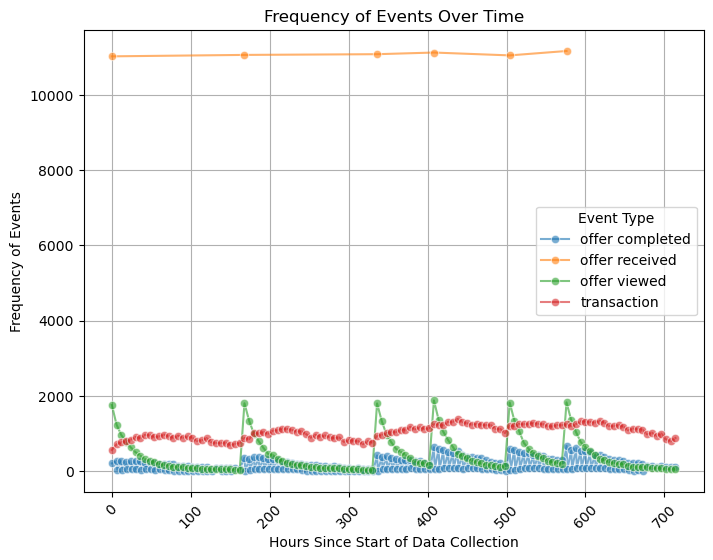

In [130]:
# Group by 'time' and 'event' to get frequency counts
event_counts_over_time = (
    transcript_clean
    .groupby(['time', 'event'])
    .size()
    .reset_index(name='count')
)
plt.figure(figsize=(8, 6))

# Use Seaborn to create a lineplot
sns.lineplot(
    data=event_counts_over_time, 
    x='time', 
    y='count', 
    hue='event', 
    marker='o',
    alpha = 0.6
)

# Customize the plot
plt.title('Frequency of Events Over Time')
plt.xlabel('Hours Since Start of Data Collection')
plt.ylabel('Frequency of Events')
plt.xticks(rotation=45)
plt.legend(title='Event Type')
plt.grid(True)

# Show the plot
plt.show()

From the figure above, it looks like that almost 2k out of 12k received events are being viewed at the same day.

In [131]:
# Time in days to measure how long does it take to resend offeres
np.sort(transcript_clean[transcript_clean['event'] == 'offer received']['time'].value_counts().index/24)

array([ 0.,  7., 14., 17., 21., 24.])

In [132]:
profile_clean.sort_values(['offer_completed','offer_viewed'],ascending = False).head(10)

,gender,age,id,became_member_on,income,offer_completed,offer_received,offer_viewed,transactions
205,F,77,78e9be059fce46a1b610f74e0e812a4a,20160219,80000.0,6,6,6,10
558,F,45,93c230e2ff31416c9fc190cd560f8653,20161124,58000.0,6,6,6,14
721,F,58,7e45faba0a8346379d0c296f1df8ae1d,20170213,92000.0,6,6,6,10
864,M,53,11739d2b18cb43eeaeefb9806a252874,20170423,40000.0,6,6,6,17
938,F,33,9b9858f0a599424688bc2c3d0d2a6d3b,20170920,41000.0,6,6,6,15
1028,F,36,846e2a96fe3249c4903cf333a15b08e5,20160829,77000.0,6,6,6,9
1435,M,51,66f8c81f38e94b889aca39805b44ea06,20170217,81000.0,6,6,6,11
1440,F,72,d24aac66f5404bc48728a207cee8b098,20170804,75000.0,6,6,6,14
1524,F,53,bb465e90882143b6a49f99d9d810dc3f,20150807,75000.0,6,6,6,12
1552,F,68,4706d17c79434626a92481776335fc61,20160529,86000.0,6,6,6,10


Seems like many people are viewing and completing all the offers that being received.

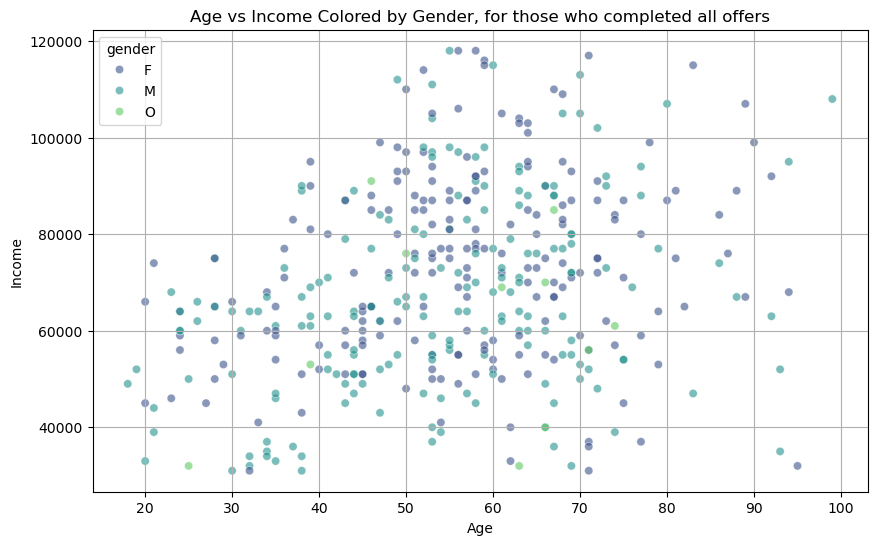

In [133]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='age', 
    y='income', 
    hue='gender', 
    data=profile_clean[(profile_clean['offer_completed'] == 6) & (profile_clean['offer_received'] == 6)], 
    palette='viridis', 
    alpha=0.6, 
)

# Adding labels and title
plt.title('Age vs Income Colored by Gender, for those who completed all offers')
plt.xlabel('Age')
plt.ylabel('Income')
plt.grid(True)

plt.show()

In [337]:
def find_offer(offer_id):
    '''
        This function finds the offer by its id and return the whole offer row
        
        input: offer_id (String)
        
        return: (Pandans DataFrame) that contains 1 row.
    '''
    return portfolio_clean[portfolio_clean['id']== offer_id]

def find_offer_id(user_id):
    '''
        This function finds the offers from the events that made by the user_id.
        Returns these offers only from the event.
        
        input: user_id (String)
        
        return: user_events (Pandans DataFrame) 
    '''
    # Retrieving the user events
    user_events = transcript_clean[transcript_clean['person'] == user_id].sort_values('time')
    
    # Returning only the events that are offers related not transactions
    return user_events[user_events['offer_id'] != 0.0][['offer_id','event']]

def complete_without_view(user_id):
    '''
        This function takes a user id, and searches for offers that he completed without receiving it.

        input: user_id (String)

        return: not_viewed (List)
    '''

    # Retrieving offers that related to user_id
    offers = find_offer_id(user_id)

    #init
    not_viewed = []
    #looping through offers events
    for _, offer in offers.iterrows():
        
        qu = offers[offers['offer_id'] == offer.iloc[0]]
        
        i = 0
        for _, of in qu.iterrows():
            
            if (of['event'] == 'offer viewed'):
                i = i-1
                continue
                
            if (of['event'] == 'offer completed'):
                i = i+1
                continue
                
        if i > 0:
            not_viewed.append(offer.iloc[0])
            break
            
        offers = offers[offers['offer_id']!= offer.iloc[0]]
        
    return not_viewed


def view_without_complete (user_id):
    '''
        This function takes user id and returns a list of offers that being viewed but not completed

        input: user_id (String)

        return: not_completed (List)
    '''
    offers = find_offer_id(user_id)
    
    not_completed = []
    
    for _, offer in offers.iterrows():
        
        qu = offers[offers['offer_id'] == offer.iloc[0]]
        
        i = 0
        for _, of in qu.iterrows():
            
            if (of['event'] == 'offer viewed'):
                i = i + 1
                continue
                
            if (of['event'] == 'offer completed'):
                i = i - 1
                continue
        
        if i > 0:
            not_completed.append(offer.iloc[0])
            
        offers = offers[offers['offer_id']!= offer.iloc[0]]
        
    return not_completed


def complete_after_view (user_id):
    
    '''
        This function takes user id and returns a list of offers that being viewed but not completed

        input: user_id (String)

        return: not_completed (List)
    '''
    # Retrieving offers that related to user_id
    offers = find_offer_id(user_id)

    #init
    completed = []
    #looping through offers events
    for _, offer in offers.iterrows():
        
        qu = offers[offers['offer_id'] == offer.iloc[0]]
        
        i = 0 # to check state
        n = 0 # count how many
        for _, of in qu.iterrows():
            
            if (i%3 == 0) and (of['event'] == 'offer received'):
                i = 1
                continue
                
            if (i == 1) and (of['event'] == 'offer viewed'):
                i = 2
                continue
                
            if (i== 2) and (of['event'] == 'offer completed'):
                i = 3
                n = n+1
                continue
            
        if i == 3:
            for _ in range(n):
                completed.append(offer.iloc[0])
            
        offers = offers[offers['offer_id']!= offer.iloc[0]]
        
    return completed




def user_offers_response(user_id):
    """
        Summarizes the response of a user to different offers.
        This function takes a user ID and returns a dictionary summarizing the user's interaction with offers.
        The summary includes:
        - Offers that were viewed and then completed.
        - Offers that were viewed but not completed.
        - Offers that were completed without being viewed.
    
        Args:
            user_id (str): The ID of the user.
    
        Returns: (dict): A dictionary with the following keys:
                - 'complete_after_view' (list): List of offer IDs that were viewed and then completed by the user.
                - 'view_without_complete' (list): List of offer IDs that were viewed but not completed by the user.
                - 'complete_without_view' (list): List of offer IDs that were completed without being viewed by the user.
    """
    return {
        'complete_after_view': complete_after_view(user_id),
        'view_without_complete': view_without_complete(user_id),
        'complete_without_view': complete_without_view(user_id)
    }

In [135]:
user_offers_response("5917d13f6fa04286abdf95f4d5cefb1e")

{'complete_after_view': ['f19421c1d4aa40978ebb69ca19b0e20d',
  '2298d6c36e964ae4a3e7e9706d1fb8c2',
  '2298d6c36e964ae4a3e7e9706d1fb8c2'],
 'view_without_complete': [],
 'complete_without_view': ['ae264e3637204a6fb9bb56bc8210ddfd']}

In [136]:
find_offer_id("5917d13f6fa04286abdf95f4d5cefb1e")

,offer_id,event
52753,f19421c1d4aa40978ebb69ca19b0e20d,offer received
67697,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed
90833,f19421c1d4aa40978ebb69ca19b0e20d,offer completed
140942,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received
162901,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed
178362,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed
187226,ae264e3637204a6fb9bb56bc8210ddfd,offer received
203688,ae264e3637204a6fb9bb56bc8210ddfd,offer completed
226557,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received
248527,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed


In [147]:
# finding users that completed offer without viewing it
profile_clean[(profile_clean['offer_completed'] > profile_clean['offer_viewed'])].sort_values('offer_completed', ascending = False)

,gender,age,id,became_member_on,income,offer_completed,offer_received,offer_viewed,transactions
10693,M,44,f5b1bf31e4484153a8d6ffbb312da4b7,20171228,51000.0,6,6,5,13
7308,M,63,f1d381a167414e6790fa19abea39d9e8,20171120,94000.0,6,6,5,9
6922,M,35,ad6a9cf0594d401c94b62590989c5644,20180604,46000.0,6,6,5,14
6928,M,20,55c44f36cd9a46079ba4ece24ebd1773,20151214,33000.0,6,6,3,14
1973,M,43,2531d3b6001a4d48bff0a91ceceb97a0,20171216,49000.0,6,6,4,16
...,...,...,...,...,...,...,...,...,...
10408,M,46,144f2b2e5def415b88d3de6b10461d26,20171004,65000.0,1,2,0,6
9376,F,64,362858ec6f754ad39c3dfd0923a677f2,20150829,93000.0,1,2,0,2
8904,M,28,0aea37c300ba4262b523881c7112484d,20150420,74000.0,1,3,0,9
8819,M,66,6eb33af1541241f9b986c48fef3822ca,20180607,83000.0,1,2,0,3


## Section : Modeling 


#### Feature Engineering
Average Time Between Receiving and Completing an Offer


In [177]:
# Extract rows for 'offer received' and 'offer completed' events
offers_received = transcript_clean[transcript_clean['event'] == 'offer received'][['person', 'offer_id', 'time']]
offers_completed = transcript_clean[transcript_clean['event'] == 'offer completed'][['person', 'offer_id', 'time']]

# Merge these dataframes on person and offer_id to get the time difference
offer_response_time = pd.merge(offers_received, offers_completed, on=['person', 'offer_id'], suffixes=('_received', '_completed'))
offer_response_time['time_to_complete'] = offer_response_time['time_completed'] - offer_response_time['time_received']

# Calculate the average time to complete an offer per user
avg_time_to_complete = offer_response_time.groupby('person')['time_to_complete'].mean()
profile_clean['avg_time_to_complete_offer'] = profile_clean['id'].map(avg_time_to_complete).fillna(0)


In [178]:
profile_clean.head()

,gender,age,id,became_member_on,income,offer_completed,offer_received,offer_viewed,transactions,avg_time_to_complete_offer
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,2,0,3,120.00
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4,4,4,7,73.75
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2,4,3,3,66.00
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,5,6,6,3,114.75
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1,3,2,4,120.00


#### Preparing data set

In [179]:
# Step 1: Prepare the dataframes for merging
profile_df = profile_clean[['id', 'age', 'gender', 'income']].rename(columns={'id': 'user_id'})
portfolio_df = portfolio_clean[['id', 'reward', 'difficulty', 'duration', 
                                'channel_email', 'channel_mobile', 'channel_social', 'channel_web']].rename(columns={'id': 'offer_id'})

# Step 2: Initialize the list to collect data
data = []

# Step 3: Loop through each user and each offer to create the feature set and label
for user_id in profile_df['user_id']:
    # Get user demographics
    user_row = profile_df[profile_df['user_id'] == user_id].iloc[0]
    age, gender, income = user_row['age'], user_row['gender'], user_row['income']
    
    # Get user offer response
    user_response = user_offers_response(user_id)
    
    for offer_id in portfolio_df['offer_id']:
        # Get offer properties
        offer_row = portfolio_df[portfolio_df['offer_id'] == offer_id].iloc[0]
        reward, difficulty, duration = offer_row['reward'], offer_row['difficulty'], offer_row['duration']
        channel_email = offer_row['channel_email']
        channel_mobile = offer_row['channel_mobile']
        channel_social = offer_row['channel_social']
        channel_web = offer_row['channel_web']
        
        # Determine label for the user-offer combination
        if offer_id in user_response['complete_after_view']:
            label = 1  # complete_after_view
        elif offer_id in user_response['view_without_complete']:
            label = 0  # view_without_complete
        elif offer_id in user_response['complete_without_view']:
            label = 2  # complete_without_view
        else:
            continue  # Skip if there's no relevant interaction

        # Append the row of data to the list
        data.append([
            user_id, offer_id, age, gender, income, reward, difficulty, duration, 
            channel_email, channel_mobile, channel_social, channel_web, label
        ])

# Step 4: Create a DataFrame from the collected data
columns = [
    'user_id', 'offer_id', 'age', 'gender', 'income', 'reward', 'difficulty', 'duration', 
    'channel_email', 'channel_mobile', 'channel_social', 'channel_web', 'label'
]
dataset = pd.DataFrame(data, columns=columns)

# Step 5: Encode categorical variables
# One-hot encode 'gender' and channels columns
dataset = pd.get_dummies(dataset, columns=['gender', 'channel_email', 'channel_mobile', 'channel_social', 'channel_web'])

# Step 6: Drop user_id and offer_id (since they are identifiers, not features)
dataset.drop(['user_id', 'offer_id'], axis=1, inplace=True)

# The resulting dataset now has features in `X` and labels in `Y`
X = dataset.drop(['label'], axis=1)
y = dataset['label']

# Simplify channel columns
dataset['channel_email'] = dataset['channel_email_1']
dataset['channel_mobile'] = dataset['channel_mobile_1']
dataset['channel_social'] = dataset['channel_social_1']
dataset['channel_web'] = dataset['channel_web_1']


channel_columns = ['channel_email', 'channel_mobile', 'channel_social', 'channel_web']
dataset[channel_columns] = dataset[channel_columns].astype(int)

# Drop the original one-hot encoded channel columns
dataset.drop(['channel_email_1', 'channel_mobile_0', 'channel_mobile_1', 
              'channel_social_0', 'channel_social_1', 'channel_web_0', 'channel_web_1'], axis=1, inplace=True)


# Simplify gender column
def simplify_gender(row):
    if row['gender_F'] == 1:
        return 0
    elif row['gender_M'] == 1:
        return 1
    else:
        return 2

dataset['gender'] = dataset.apply(simplify_gender, axis=1)

# Drop the original one-hot encoded gender columns
dataset.drop(['gender_F', 'gender_M', 'gender_O','channel_email'], axis=1, inplace=True)

# Inspect the modified dataset
dataset.head()


,age,income,reward,difficulty,duration,label,gender_F,gender_M,gender_O,channel_email_1,channel_mobile_0,channel_mobile_1,channel_social_0,channel_social_1,channel_web_0,channel_web_1
0,55,112000.0,5,5,7,2,True,False,False,True,False,True,True,False,False,True
1,75,100000.0,10,10,7,1,True,False,False,True,False,True,False,True,True,False
2,75,100000.0,5,5,7,1,True,False,False,True,False,True,True,False,False,True
3,75,100000.0,0,0,3,1,True,False,False,True,False,True,False,True,True,False
4,68,70000.0,5,5,7,1,False,True,False,True,False,True,True,False,False,True


In [265]:
dataset_wo2 = dataset[(dataset['label'] != 2)]

In [286]:
dataset_wo2.drop('label',axis = 1).drop_duplicates(inplace = True)

,age,income,reward,difficulty,duration,label,channel_email_x,channel_mobile_x,channel_social,channel_web,gender,offer_type
0,75,100000.0,10,10,7,1,1,1,1,0,0,bogo
1,75,100000.0,5,5,7,1,1,1,0,1,0,bogo
2,75,100000.0,0,0,3,1,1,1,1,0,0,informational
3,68,70000.0,5,5,7,1,1,1,0,1,1,bogo
4,68,70000.0,2,10,10,1,1,1,1,1,1,discount
...,...,...,...,...,...,...,...,...,...,...,...,...
37732,45,54000.0,0,0,3,0,1,1,1,0,0,informational
37733,61,72000.0,0,0,3,0,1,1,1,0,1,informational
37734,49,73000.0,0,0,3,1,1,1,1,0,1,informational
37735,83,50000.0,10,10,5,1,1,1,1,1,0,bogo


In [266]:
from collections import Counter

# Identifying duplicated rows based on feature columns (excluding the label)
duplicates = dataset_wo2.loc[dataset_wo2.drop('label', axis=1).duplicated(keep=False)]

# Grouping duplicates by their features
grouped_duplicates = duplicates.groupby(list(dataset_wo2.drop('label', axis=1).columns))

# Creating a dictionary to store new labels for each group
label_updates = {}

# Loop through each group of duplicates and set the most common label
for _, group in grouped_duplicates:
    # Find the most common label in the group
    most_common_label = Counter(group['label']).most_common(1)[0][0]
    # Store the new label
    label_updates.update({idx: most_common_label for idx in group.index})

# Update the labels in the original dataset
dataset_wo2.loc[label_updates.keys(), 'label'] = dataset_wo2.loc[label_updates.keys()].index.map(label_updates)

# Verify if the duplicates now have the same label
dataset_wo2.loc[dataset_wo2.drop('label', axis=1).duplicated()].sort_values(['income','age','reward','duration'], ascending = False)

,age,income,reward,difficulty,duration,label,channel_email,channel_mobile,channel_social,channel_web,gender
40169,76,119000.0,0,0,3,0,1,1,1,0,0
36290,68,119000.0,3,7,7,1,1,1,1,1,0
1380,65,119000.0,10,10,5,1,1,1,1,1,0
32291,65,119000.0,10,10,5,1,1,1,1,1,0
1382,65,119000.0,2,10,10,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
33556,25,30000.0,5,5,5,1,1,1,1,1,1
39408,20,30000.0,10,10,5,0,1,1,1,1,1
22632,19,30000.0,10,10,7,0,1,1,1,0,1
22633,19,30000.0,3,7,7,1,1,1,1,1,1


In [277]:
dataset_wo2['label'].value_counts()

label
1    22580
0    15157
Name: count, dtype: int64

#### Building ML model

In [387]:
X = dataset_wo2.drop(['label'], axis=1)
y = dataset_wo2['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (30189, 10), Test set: (7548, 10)


In [404]:
# Instantiate the model
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

In [405]:
y_pred = rf_classifier.predict(X_test)


In [406]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      3078
           1       0.75      0.80      0.78      4470

    accuracy                           0.73      7548
   macro avg       0.72      0.71      0.71      7548
weighted avg       0.72      0.73      0.72      7548

Confusion Matrix:
[[1918 1160]
 [ 905 3565]]


In [409]:
# Parameters for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=   4.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=   4.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=   4.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END max_depth=None, min_s

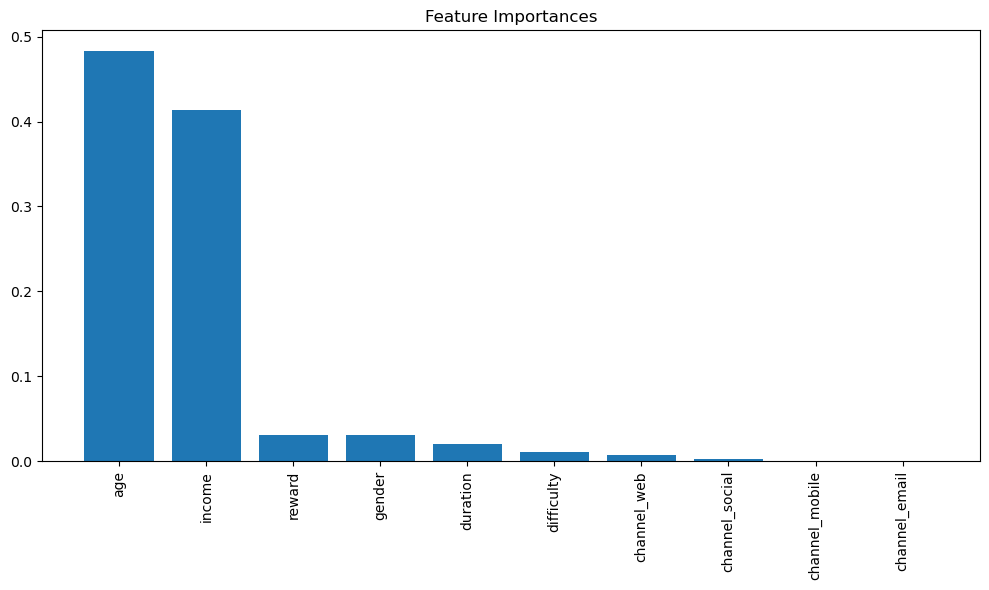

In [272]:
# Get feature importances
feature_importances = best_rf.feature_importances_ if 'best_rf' in locals() else rf_classifier.feature_importances_
features = X.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

In [278]:
# Features and labels
X = dataset_wo2.drop('label', axis=1)
y = dataset_wo2['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Dictionary to hold models and their names
models = {
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42, max_depth = 20, min_samples_split = 2),
    "Logistic Regression": LogisticRegression( random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
}

# Iterate through models and evaluate them
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    
    # Classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print('-' * 60)

Training set: (30189, 10), Test set: (7548, 10)
Random Forest Accuracy: 0.72
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      3078
           1       0.75      0.81      0.78      4470

    accuracy                           0.72      7548
   macro avg       0.72      0.70      0.71      7548
weighted avg       0.72      0.72      0.72      7548

------------------------------------------------------------


C:\Users\yoyo\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.64
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.36      0.45      3078
           1       0.65      0.84      0.73      4470

    accuracy                           0.64      7548
   macro avg       0.63      0.60      0.59      7548
weighted avg       0.63      0.64      0.62      7548

------------------------------------------------------------
Support Vector Machine Accuracy: 0.59
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.14      0.22      3078
           1       0.60      0.91      0.73      4470

    accuracy                           0.59      7548
   macro avg       0.56      0.52      0.47      7548
weighted avg       0.56      0.59      0.52      7548

------------------------------------------------------------
K-Nearest Neighbors Accuracy: 0.65
K-Nearest Neighbors Classif

C:\Users\yoyo\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:27:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.67
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.46      0.54      3078
           1       0.69      0.82      0.75      4470

    accuracy                           0.67      7548
   macro avg       0.66      0.64      0.64      7548
weighted avg       0.67      0.67      0.66      7548

------------------------------------------------------------


In [279]:
# predictions = rf_classifier.predict(new_X)

# print("Predicted offer responses:", predictions)

#### Hurestic Approach

In [299]:
df_h = dataset_wo2.merge(portfolio_clean, left_on= ['reward','difficulty','duration','channel_social','channel_web'], right_on =['reward','difficulty','duration','channel_social','channel_web'] ).drop(['channel_email_y', 'channel_mobile_y'], axis = 1)

In [417]:
# Calculate response rates
bins = [17, 24, 34, 44, 54, 64, 74, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
df_h['age_group'] = pd.cut(df_h['age'], bins=bins, labels=labels)


response_summary = df_h.groupby(['age_group', 'gender', 'id'], observed = False).agg(
    total_offers=('label', 'count'),
    responses=('label', 'sum'),
).reset_index()

# Calculate response rate
response_summary['response_rate'] = response_summary['responses'] / response_summary['total_offers']


response_merged = response_summary.sort_values(['response_rate','total_offers'],ascending = False).merge(portfolio[['id','offer_type','reward','duration','difficulty','channels']], left_on= 'id', right_on= 'id')
response_merged

,age_group,gender,id,total_offers,responses,response_rate,offer_type,reward,duration,difficulty,channels
0,25-34,2,fafdcd668e3743c1bb461111dcafc2a4,5,5,1.000000,discount,2,10,10,"[web, email, mobile, social]"
1,75+,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,5,1.000000,discount,5,10,20,"[web, email]"
2,75+,2,2906b810c7d4411798c6938adc9daaa5,5,5,1.000000,discount,2,7,10,"[web, email, mobile]"
3,25-34,2,2298d6c36e964ae4a3e7e9706d1fb8c2,4,4,1.000000,discount,3,7,7,"[web, email, mobile, social]"
4,25-34,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,2,1.000000,discount,5,10,20,"[web, email]"
...,...,...,...,...,...,...,...,...,...,...,...
205,18-24,2,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0.200000,bogo,5,5,5,"[web, email, mobile, social]"
206,25-34,1,4d5c57ea9a6940dd891ad53e9dbe8da0,323,47,0.145511,bogo,10,5,10,"[web, email, mobile, social]"
207,18-24,1,4d5c57ea9a6940dd891ad53e9dbe8da0,224,29,0.129464,bogo,10,5,10,"[web, email, mobile, social]"
208,18-24,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0.000000,discount,5,10,20,"[web, email]"


In [419]:
# Saving this to CSV so we Can load it in the script

response_merged.to_csv('offer_recommendations.csv', index=False)

In [379]:
# Assign age groups
# TRYing############## TRYING #######################
df_customers = df_h[['age','gender','age_group']]

# Merge DataFrames
merged_df = pd.merge(df_customers, response_summary, on=['age_group', 'gender'])

# Sort by customer_id and response_rate descending
merged_df = merged_df.sort_values(['response_rate','total_offers'], ascending=False)
merged_df.merge(portfolio[['id','offer_type','reward','duration','difficulty']], left_on= 'id', right_on= 'id').sort_values('total_offers',ascending = False)

,age,gender,age_group,id,total_offers,responses,response_rate,offer_type,reward,duration,difficulty
53327,63,1,55-64,fafdcd668e3743c1bb461111dcafc2a4,609,453,0.743842,discount,2,10,10
55928,59,1,55-64,fafdcd668e3743c1bb461111dcafc2a4,609,453,0.743842,discount,2,10,10
55926,59,1,55-64,fafdcd668e3743c1bb461111dcafc2a4,609,453,0.743842,discount,2,10,10
55925,56,1,55-64,fafdcd668e3743c1bb461111dcafc2a4,609,453,0.743842,discount,2,10,10
55924,56,1,55-64,fafdcd668e3743c1bb461111dcafc2a4,609,453,0.743842,discount,2,10,10
...,...,...,...,...,...,...,...,...,...,...,...
339,22,2,18-24,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1.000000,bogo,10,5,10
338,22,2,18-24,2906b810c7d4411798c6938adc9daaa5,1,1,1.000000,discount,2,7,10
337,22,2,18-24,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1.000000,bogo,5,7,5
336,22,2,18-24,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1.000000,bogo,10,5,10


In [333]:
# Drop duplicates to keep the best offer per customer
best_offers = merged_df.drop_duplicates(subset=['age','gender','id'], keep='first')

# Assign offers, fill missing with 'default_offer'
df_customers = df_customers.merge(
    best_offers[['age','gender', 'id']],
    on=['age','gender'],
)
df_customers['offer'] = df_customers['id'].fillna('default_offer')

# Drop the temporary 'id' column if desired
df_customers = df_customers.drop(columns=['id', 'age_group'])

df_customers

,age,gender,offer
0,75,0,fafdcd668e3743c1bb461111dcafc2a4
1,75,0,2298d6c36e964ae4a3e7e9706d1fb8c2
2,75,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,75,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
4,75,0,2906b810c7d4411798c6938adc9daaa5
...,...,...,...
377215,62,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
377216,62,0,f19421c1d4aa40978ebb69ca19b0e20d
377217,62,0,4d5c57ea9a6940dd891ad53e9dbe8da0
377218,62,0,3f207df678b143eea3cee63160fa8bed


,reward,difficulty,duration,offer_type,id,channel_email,channel_mobile,channel_social,channel_web
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
...,...,...,...,...,...,...,...,...,...
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1


In [375]:
 # Extract the first row from each DataFrame

# Add these columns to the original DataFrame
best_offer_user = df_customers.merge(portfolio[['id','offer_type','reward','duration','difficulty']], left_on= 'offer', right_on= 'id')
best_offer_user.drop('id', axis = 1).merge(profile_clean[['age','gender','id']], left_on= ['age','gender'])

,age,gender,offer,offer_type,reward,duration,difficulty
0,75,0,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10,10
1,75,0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,7,7
2,75,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5
3,75,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,10,20
4,75,0,2906b810c7d4411798c6938adc9daaa5,discount,2,7,10
...,...,...,...,...,...,...,...
377215,62,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,10,20
377216,62,0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5
377217,62,0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,10
377218,62,0,3f207df678b143eea3cee63160fa8bed,informational,0,4,0


The data above describes people without ids, just age and gender.

In [ ]:
best_offer_user.head(20)